**Dependencies**

In [15]:
import sys
from obspy import UTCDateTime
from DataDownload import *
from StreamProcessing import *
from EventIdentification import *
from CataloguedEvents import *
from utils import *
import matplotlib.pyplot as plt
from obspy import UTCDateTime


**Set Date And Station**

In [16]:
date = UTCDateTime("2024-02-07") 

# station = ['GB', 'EDMD', 'IRIS']
station = ['AM','R50D6','https://data.raspberryshake.org']

# get the coordination for the station
station_coordinates = get_coordinates(station)

# Try to download data and return availability for the date
data_available = download_seismic_data(date, station)

Data for 2024-02-07 already downloaded.


**Original Stream**

1 Trace(s) in Stream:
AM.R50D6.00.EHZ | 2024-02-07T14:11:47.675000Z - 2024-02-08T01:00:00.005000Z | 100.0 Hz, 3889234 samples


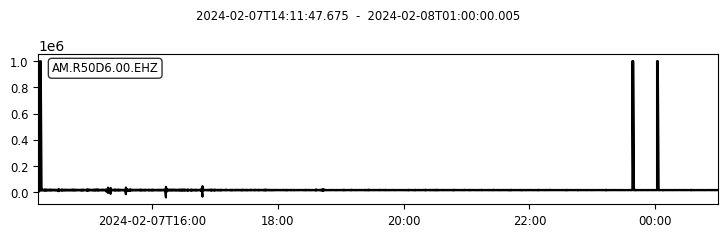

In [17]:
# Get stream from mseed file using date and st
stream = get_stream(date, station)
print(stream)

# Before processing
stream.plot()
plt.show()
plt.close()

**Processed Stream**

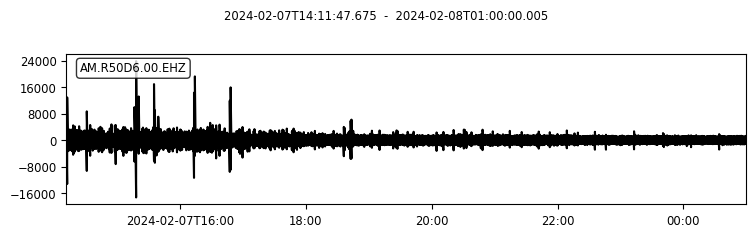

In [18]:
processed_stream = stream_process(stream)
processed_stream.plot()
plt.show()
plt.close()

**Find Earthquake From Catalogue**

Number of Identified Earthquakes: 1
1 Event(s) in Catalog:
2024-02-07T02:04:53.438000Z | +13.159,  -89.592 | 5.0  mb | manual


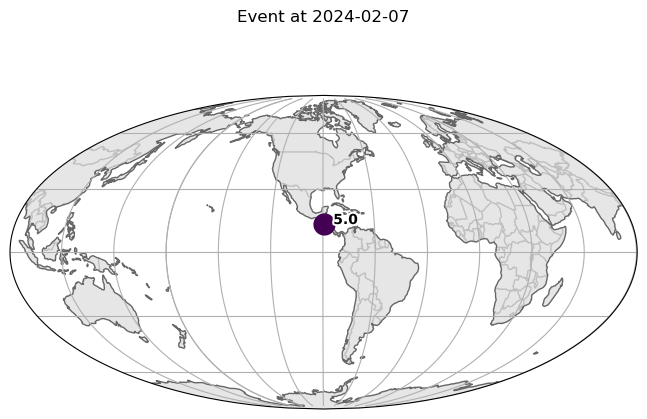

In [19]:
catalogued_earthquakes = find_earthquakes(
    catalogue_provider='USGS',
    latitude=station_coordinates[0],
    longitude=station_coordinates[1],
    date = date,
    radmin=0,
    radmax=90,
    minmag=5,
    maxmag=10
)

print_catalogued(catalogued_earthquakes)

**Create a DataFrame for Catalogued Events with Predicted Arrival Times**

In [20]:
df_catalogued = create_df_with_prediction(catalogued_earthquakes, station_coordinates)
df_catalogued

,time,lat,long,mag,mag_type,P_predict,S_predict,catalogued,detected,detected_start,detected_end
0,2024-02-07T02:04:53.438000,13.1591,-89.5919,5.0,mb,2024-02-07T02:16:45.429840,2024-02-07T02:26:35.056591,True,False,None,None


**Create a DataFrame for Events Identified Using STA/ LTA**

In [28]:
df_detected = detect_earthquakes(
    processed_stream,
    sta_window=0.5,      # Short-time window in seconds
    lta_window=10.0,   # Long-time window in seconds
    threshold_on=3,    # STA/LTA threshold for triggering
    threshold_off=1    # STA/LTA threshold for turning off the trigger
)

df_detected

,detected_start,detected_end
0,2024-02-07T14:12:24.445000,2024-02-07T14:12:24.945000
1,2024-02-07T14:12:58.675000,2024-02-07T14:12:59.945000
2,2024-02-07T14:13:10.785000,2024-02-07T14:13:12.705000
3,2024-02-07T14:13:14.755000,2024-02-07T14:13:15.645000
4,2024-02-07T14:13:34.715000,2024-02-07T14:13:35.075000
...,...,...
333,2024-02-08T00:15:39.345000,2024-02-08T00:15:39.825000
334,2024-02-08T00:21:11.155000,2024-02-08T00:21:11.925000
335,2024-02-08T00:33:35.125000,2024-02-08T00:33:36.215000
336,2024-02-08T00:42:21.715000,2024-02-08T00:42:22.195000


**Compare DataFrames And Merge Events Detected In Catalogue**

In [29]:
result_df = match_and_merge(df_catalogued, df_detected)
print_statistics(result_df)

Earthquake Detection Statistics:
-------------------------------
Detected in Catalogue: 0
Not Detected in Catalogue: 1
Detected but Not in Catalogue: 338


In [23]:
catalogued_and_detected_plot(result_df, processed_stream)